In [1]:
from __future__ import annotations
from typing import Optional
import pandas as pd 
from copy import deepcopy
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import seaborn as sns


Load data

In [2]:
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020.clean.tsv'

In [3]:
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')
master = master.loc[master['diagnosis_year'] >= 2010]
master.head()

,patient_id,patient_death_year,diagnosis_year,diagnosis_agebin,site,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,...,breast_subtype,hist_type,hist_cateogry,site_category,primary_site,brain_met,bone_met,lung_met,liver_met,distant_ln
0,98,NaN,2015,75-79 years,Vulva,Tis,N0,0,NaN,NaN,...,NaN,8542,8500-8549: ductal and lobular neoplasms,Vulva,Vulva,False,False,False,False,NaN
1,123,2017.0,2012,85-89 years,Myeloma,NaN,NaN,NaN,NaN,NaN,...,NaN,9732,9730-9739: plasma cell tumors,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN
4,124,2011.0,2010,70-74 years,Breast,T3,N0,IIB,NaN,NaN,...,HR-/HER2-,8500,8500-8549: ductal and lobular neoplasms,Breast,Breast,False,False,False,False,NaN
5,125,NaN,2018,70-74 years,Breast,T2,N0,IIA,NaN,NaN,...,HR-/HER2-,8500,8500-8549: ductal and lobular neoplasms,Breast,Breast,False,False,False,False,False
6,179,NaN,2016,55-59 years,Ovary,T1c,N0,IC,P,P,...,NaN,8441,"8440-8499: cystic, mucinous and serous neoplasms",Ovary,Ovary,False,False,False,False,False


In [30]:
weird_pids = master[master['site'] != master['primary_site']]['patient_id']
weird_pids = set(weird_pids.to_list())

mismatch_df = master[master['patient_id'].isin(weird_pids)]
# print(mismatch_df.shape)
# print(mismatch_df.head())
singles_df = mismatch_df.drop_duplicates(subset=['patient_id'], keep=False)
multiples_df = mismatch_df[mismatch_df.duplicated(subset=['patient_id'], keep=False)]
# print(singles_df.shape)
# print(singles_df.head())

# only interested in pure mismatches
combinations = pd.DataFrame()
combinations['site'] = singles_df['site']
combinations['site_category'] = singles_df['site_category']
combinations['primary_site'] = singles_df['primary_site']
combinations['site|primary_site'] = combinations['site'] + '|' + combinations['primary_site']
combinations['site_category|primary_site'] = combinations['site_category'] + '|' + combinations['primary_site']
# print(combinations['site|primary_site'].value_counts().head(10))
print(combinations['site_category|primary_site'].value_counts().head(20))

"""
site_category|primary_site
Non-Hodgkin Lymphoma|Nodal (MSM) | Miscellaneous     97818
Miscellaneous|Leukemia                               71056
Myeloma|Leukemia                                     57624
Hodgkin Lymphoma|Nodal (MSM) | Miscellaneous         21241
Mouth|Tonsil | Nodal (MSM)                           15602
Non-Hodgkin Lymphoma|Skin                            11665
Non-Hodgkin Lymphoma|Leukemia                         7308
Mesothelioma|Pleura                                   6144
"""

# print(multiples_df.shape)
# print(multiples_df.head())

# common mismatches
# Myeloma | Leukemia 

site_category|primary_site
Skin|Skin                                           318707
Leukemia|Leukemia                                   115375
Non-Hodgkin Lymphoma|Nodal (MSM) | Miscellaneous     97818
Miscellaneous|Leukemia                               71056
Myeloma|Leukemia                                     57624
Hodgkin Lymphoma|Nodal (MSM) | Miscellaneous         21241
Mouth|Tonsil | Nodal (MSM)                           15602
Non-Hodgkin Lymphoma|Skin                            11665
Non-Hodgkin Lymphoma|Leukemia                         7308
Mesothelioma|Pleura                                   6144
Non-Hodgkin Lymphoma|Stomach                          5661
Non-Hodgkin Lymphoma|Brain                            3395
Kaposi Sarcoma|Skin                                   3043
Non-Hodgkin Lymphoma|Small Intestine                  2902
Non-Hodgkin Lymphoma|Nodal (MSM)                      2495
Non-Hodgkin Lymphoma|Lung and Bronchus                2098
Non-Hodgkin Lymphoma|Eye and 

'\nsite|primary_site\nMelanoma of the Skin|Skin                      303318\nNHL - Nodal|Nodal (MSM) | Miscellaneous         97818\nMiscellaneous|Leukemia                          71056\nMyeloma|Leukemia                                57624\nChronic Lymphocytic Leukemia|Leukemia           40392\nAcute Myeloid Leukemia|Leukemia                 32313\nHodgkin - Nodal|Nodal (MSM) | Miscellaneous     21241\nTonsil|Tonsil | Nodal (MSM)                     15602\nChronic Myeloid Leukemia|Leukemia               15538\nOther Non-Epithelial Skin|Skin                  15389\n\nsite_category|primary_site\nNon-Hodgkin Lymphoma|Nodal (MSM) | Miscellaneous     97818\nMiscellaneous|Leukemia                               71056\nMyeloma|Leukemia                                     57624\nHodgkin Lymphoma|Nodal (MSM) | Miscellaneous         21241\nMouth|Tonsil | Nodal (MSM)                           15602\nNon-Hodgkin Lymphoma|Skin                            11665\nNon-Hodgkin Lymphoma|Leukemia         

Standardisation

In [4]:
import re 
import numpy as np

df = pd.DataFrame()

TSTAGE_PATTERN = r'^(T[1234])'
NSTAGE_PATTERN = r'^(N[0123])'
GSTAGE_PATTERN = r'^(IV|III|II|I|0)'

def std_tstage(stage: str | float) -> str | float:
    """
    target: {T1, T2, T3, T4}
    T1a -> T1 etc
    ignore T0, TX, Ta, Tis, Tispd etc. 
    """
    if isinstance(stage, str):
        m = re.match(TSTAGE_PATTERN, stage)
        if m:
            return m.group(1)
    return np.nan

def std_nstage(stage: str | float) -> str | float:
    """
    target: {N0, N1, N2, N3}
    ignore NX
    N0: no detectable lymph nodes (ie no spread)
    """
    if isinstance(stage, str):
        m = re.match(NSTAGE_PATTERN, stage)
        if m:
            return m.group(1)
    return np.nan

def std_gstage(stage: str | float) -> str | float:
    """
    target: {N0, N1, N2, N3}
    ignore NX
    N0: no detectable lymph nodes (ie no spread)
    """
    if isinstance(stage, str):
        if stage == 'OCCULT':
            return np.nan
        m = re.match(GSTAGE_PATTERN, stage)
        assert m 
        return m.group(1)
    return np.nan

master['TSTAGE_STD'] = master['t_stage_ajcc'].apply(std_tstage)
master['NSTAGE_STD'] = master['n_stage_ajcc'].apply(std_nstage)
master['GSTAGE_STD'] = master['g_stage_ajcc'].apply(std_gstage)
master['brain_met'] = master['brain_met'].apply(lambda x: 'YES' if x else 'NO')
master = master.rename(columns={'grade': 'GRADE', 'hist_cateogry': 'HISTOLOGY', 'brain_met': 'BRAIN_MET', 'site_category': 'SITE'})
master.head()


,patient_id,patient_death_year,diagnosis_year,diagnosis_agebin,site,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,...,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,SITE,primary_site,BRAIN_MET,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD
0,98,NaN,2015,75-79 years,Vulva,Tis,N0,0,NaN,NaN,...,NaN,BENIGN,2,0,Vulva,518,NO,NaN,N0,0
1,123,2017.0,2012,85-89 years,Myeloma,NaN,NaN,NaN,NaN,NaN,...,NaN,MALIGNANT,2,0,Myeloma,421,NO,NaN,NaN,NaN
4,124,2011.0,2010,70-74 years,Breast,T3,N0,IIB,NaN,NaN,...,NEG,MALIGNANT,3,0,Breast,509,NO,T3,N0,II
5,125,NaN,2018,70-74 years,Breast,T2,N0,IIA,NaN,NaN,...,NEG,MALIGNANT,2,0,Breast,508,NO,T2,N0,II
6,179,NaN,2016,55-59 years,Ovary,T1c,N0,IC,P,P,...,NEG,MALIGNANT,2,0,Ovary,569,NO,T1,N0,I


---------------

## Record-Level Analysis 



Loading data

In [6]:
# TODO improve
records_df = master.drop_duplicates(subset=['patient_id'], keep='last')
print(records_df.shape)
records_df.head()



(4749544, 25)


,patient_id,patient_death_year,diagnosis_year,diagnosis_agebin,site,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,...,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,SITE,primary_site,BRAIN_MET,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD
0,98,NaN,2015,75-79 years,Vulva,Tis,N0,0,NaN,NaN,...,NaN,BENIGN,2,0,Vulva,518,NO,NaN,N0,0
1,123,2017.0,2012,85-89 years,Myeloma,NaN,NaN,NaN,NaN,NaN,...,NaN,MALIGNANT,2,0,Myeloma,421,NO,NaN,NaN,NaN
4,124,2011.0,2010,70-74 years,Breast,T3,N0,IIB,NaN,NaN,...,NEG,MALIGNANT,3,0,Breast,509,NO,T3,N0,II
5,125,NaN,2018,70-74 years,Breast,T2,N0,IIA,NaN,NaN,...,NEG,MALIGNANT,2,0,Breast,508,NO,T2,N0,II
6,179,NaN,2016,55-59 years,Ovary,T1c,N0,IC,P,P,...,NEG,MALIGNANT,2,0,Ovary,569,NO,T1,N0,I


In [113]:
records_df['SITE'].value_counts()

SITE
Breast                                               763723
Prostate                                             537181
Lung and Bronchus                                    501394
Skin                                                 385313
Colorectal                                           365824
Non-Hodgkin Lymphoma                                 176061
Urinary Bladder                                      164179
Miscellaneous                                        153816
Kidney and Renal Pelvis                              151426
Uterus                                               139668
Leukemia                                             132773
Pancreas                                             131818
Thyroid                                              127807
Cranial Nerves Other Nervous System                  119673
Mouth                                                 90382
Liver                                                 81442
Brain                              

In [102]:
# mutual information 
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_validate
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, LinearColorMapper
from bokeh.palettes import Spectral10
output_notebook()

def confusion_matrix(df: pd.DataFrame, col1: str, col2: str):
    return df.groupby([col1, col2]).size().unstack(fill_value=0)

def do_mutual_information(df: pd.DataFrame, cat1: str, cat2: str) -> float:
    temp = df[[cat1, cat2]]
    temp = temp.dropna()
    # temp = temp.reset_index(drop=True)
    # print(f'\n\n{cat1} vs {cat2} ({df.shape[0]} records) ---')
    
    c_matrix = confusion_matrix(temp, cat2, cat1)
    # print(c_matrix)
    # print()

    mi3 = normalized_mutual_info_score(labels_pred=temp[cat1], labels_true=temp[cat2])
    # print(f'Mutual Information (normalized): {mi3:0.3f}')
    return float(mi3)

def do_pca(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna()
    df = df.reset_index(drop=True)
    bm_series = df['BRAIN_MET']
    df = df.drop('BRAIN_MET', axis=1)
    # print(df.shape)
    # print(df.head())
    reducer = PCA(n_components=2)
    embedding = reducer.fit_transform(df.to_numpy())
    embedding_df = pd.DataFrame(embedding, columns=('x', 'y'))
    embedding_df.index = df.index
    embedding_df = pd.merge(df, embedding_df, left_index=True, right_index=True)
    embedding_df['BRAIN_MET'] = bm_series
    return embedding_df

def plot_interactive(df: pd.DataFrame, title: str, color_by: str='BRAIN_MET'):
    assert color_by in df.columns
    
    # categorical
    if color_by in df.columns:
        if color_by == 'BRAIN_MET':
            palette = ('#e6194b', '#3cb44b')
        # if color_by == 'primary':
        #     palette = ('#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000')
        # elif color_by == 'common':
        #     palette = ('#e6194b', '#3cb44b')
        # elif color_by == 'gender':
        #     palette = ('#e6194b', '#3cb44b')
        # elif color_by == 'batch':
        #     palette = ('#ffe119', '#4363d8', '#f58231')
        # elif color_by == 'hlfa':
        #     palette = ('#e6194b', '#3cb44b')
        the_mapper = CategoricalColorMapper(factors=df[color_by].unique(), palette=palette)

    # # continuous
    # elif color_by in ['age','purity','ploidy','loh','pga']:
    #     the_mapper = LinearColorMapper(palette='Magma256',low=df[color_by].min(),high=df[color_by].max())
    # else:
    #     raise ValueError("Invalid color_by value")

    plot_figure = figure(
        title=title,
        width=1000,
        height=600,
        tools=('pan, wheel_zoom, reset')
    )

    attributes = [x for x in df.columns if x not in ['x', 'y']]
    templ = """
    <div>
    """
    for att in attributes:
        templ += f"""
        <div>
            <span style='font-size: 16px; color: #224499'>{att}:</span>
            <span style='font-size: 16px'>@{att}</span>
        </div>
        """
    templ += """
    <div>
    """
    
    plot_figure.add_tools(HoverTool(tooltips=templ))

    datasource = ColumnDataSource(df)
    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field=color_by, transform=the_mapper),
        line_alpha=0.6,
        fill_alpha=0.6,
        size=8,
        legend_label=color_by
    )
    show(plot_figure)

def do_decision_tree(df: pd.DataFrame, title: str, target: str) -> None:
    df = df.dropna()
    min_samples_leaf = max(df.shape[0]//100, 1)
    df.head()
    X = df.drop(target, axis=1)
    Y = df[target]
    clf = DecisionTreeClassifier(max_leaf_nodes=12, max_depth=5, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(X, Y)
    
    fig = plt.figure(figsize=(40, 40))
    _ = plot_tree(clf, feature_names=X.columns.to_list(), filled=True, proportion=False)
    plt.title(title)

    clf = DecisionTreeClassifier(max_leaf_nodes=12)
    scores = cross_validate(clf, X, Y, cv=3, scoring=('recall', 'precision', 'accuracy', 'f1'))

    print('\nMETRICS ---')
    for k, v in scores.items():
        print(f'{k}: {np.mean(v):0.3f}')
        

Loading BokehJS ...



 --- Lung and Bronchus --- 
Decision tree using 115902 records (balanced classes).

METRICS ---
fit_time: 0.014
score_time: 0.012
test_recall: 0.597
test_precision: 0.610
test_accuracy: 0.694
test_f1: 0.602


 --- Esophagus --- 
Decision tree using 1474 records (balanced classes).

METRICS ---
fit_time: 0.001
score_time: 0.005
test_recall: 0.527
test_precision: 0.645
test_accuracy: 0.734
test_f1: 0.579


 --- Skin --- 
Decision tree using 6026 records (balanced classes).

METRICS ---
fit_time: 0.001
score_time: 0.005
test_recall: 0.472
test_precision: 0.750
test_accuracy: 0.696
test_f1: 0.550


 --- Breast --- 
Decision tree using 5516 records (balanced classes).

METRICS ---
fit_time: 0.002
score_time: 0.005
test_recall: 0.754
test_precision: 0.767
test_accuracy: 0.839
test_f1: 0.760


 --- Prostate --- 
Decision tree using 876 records (balanced classes).

METRICS ---
fit_time: 0.001
score_time: 0.005
test_recall: 0.299
test_precision: 0.713
test_accuracy: 0.825
test_f1: 0.420


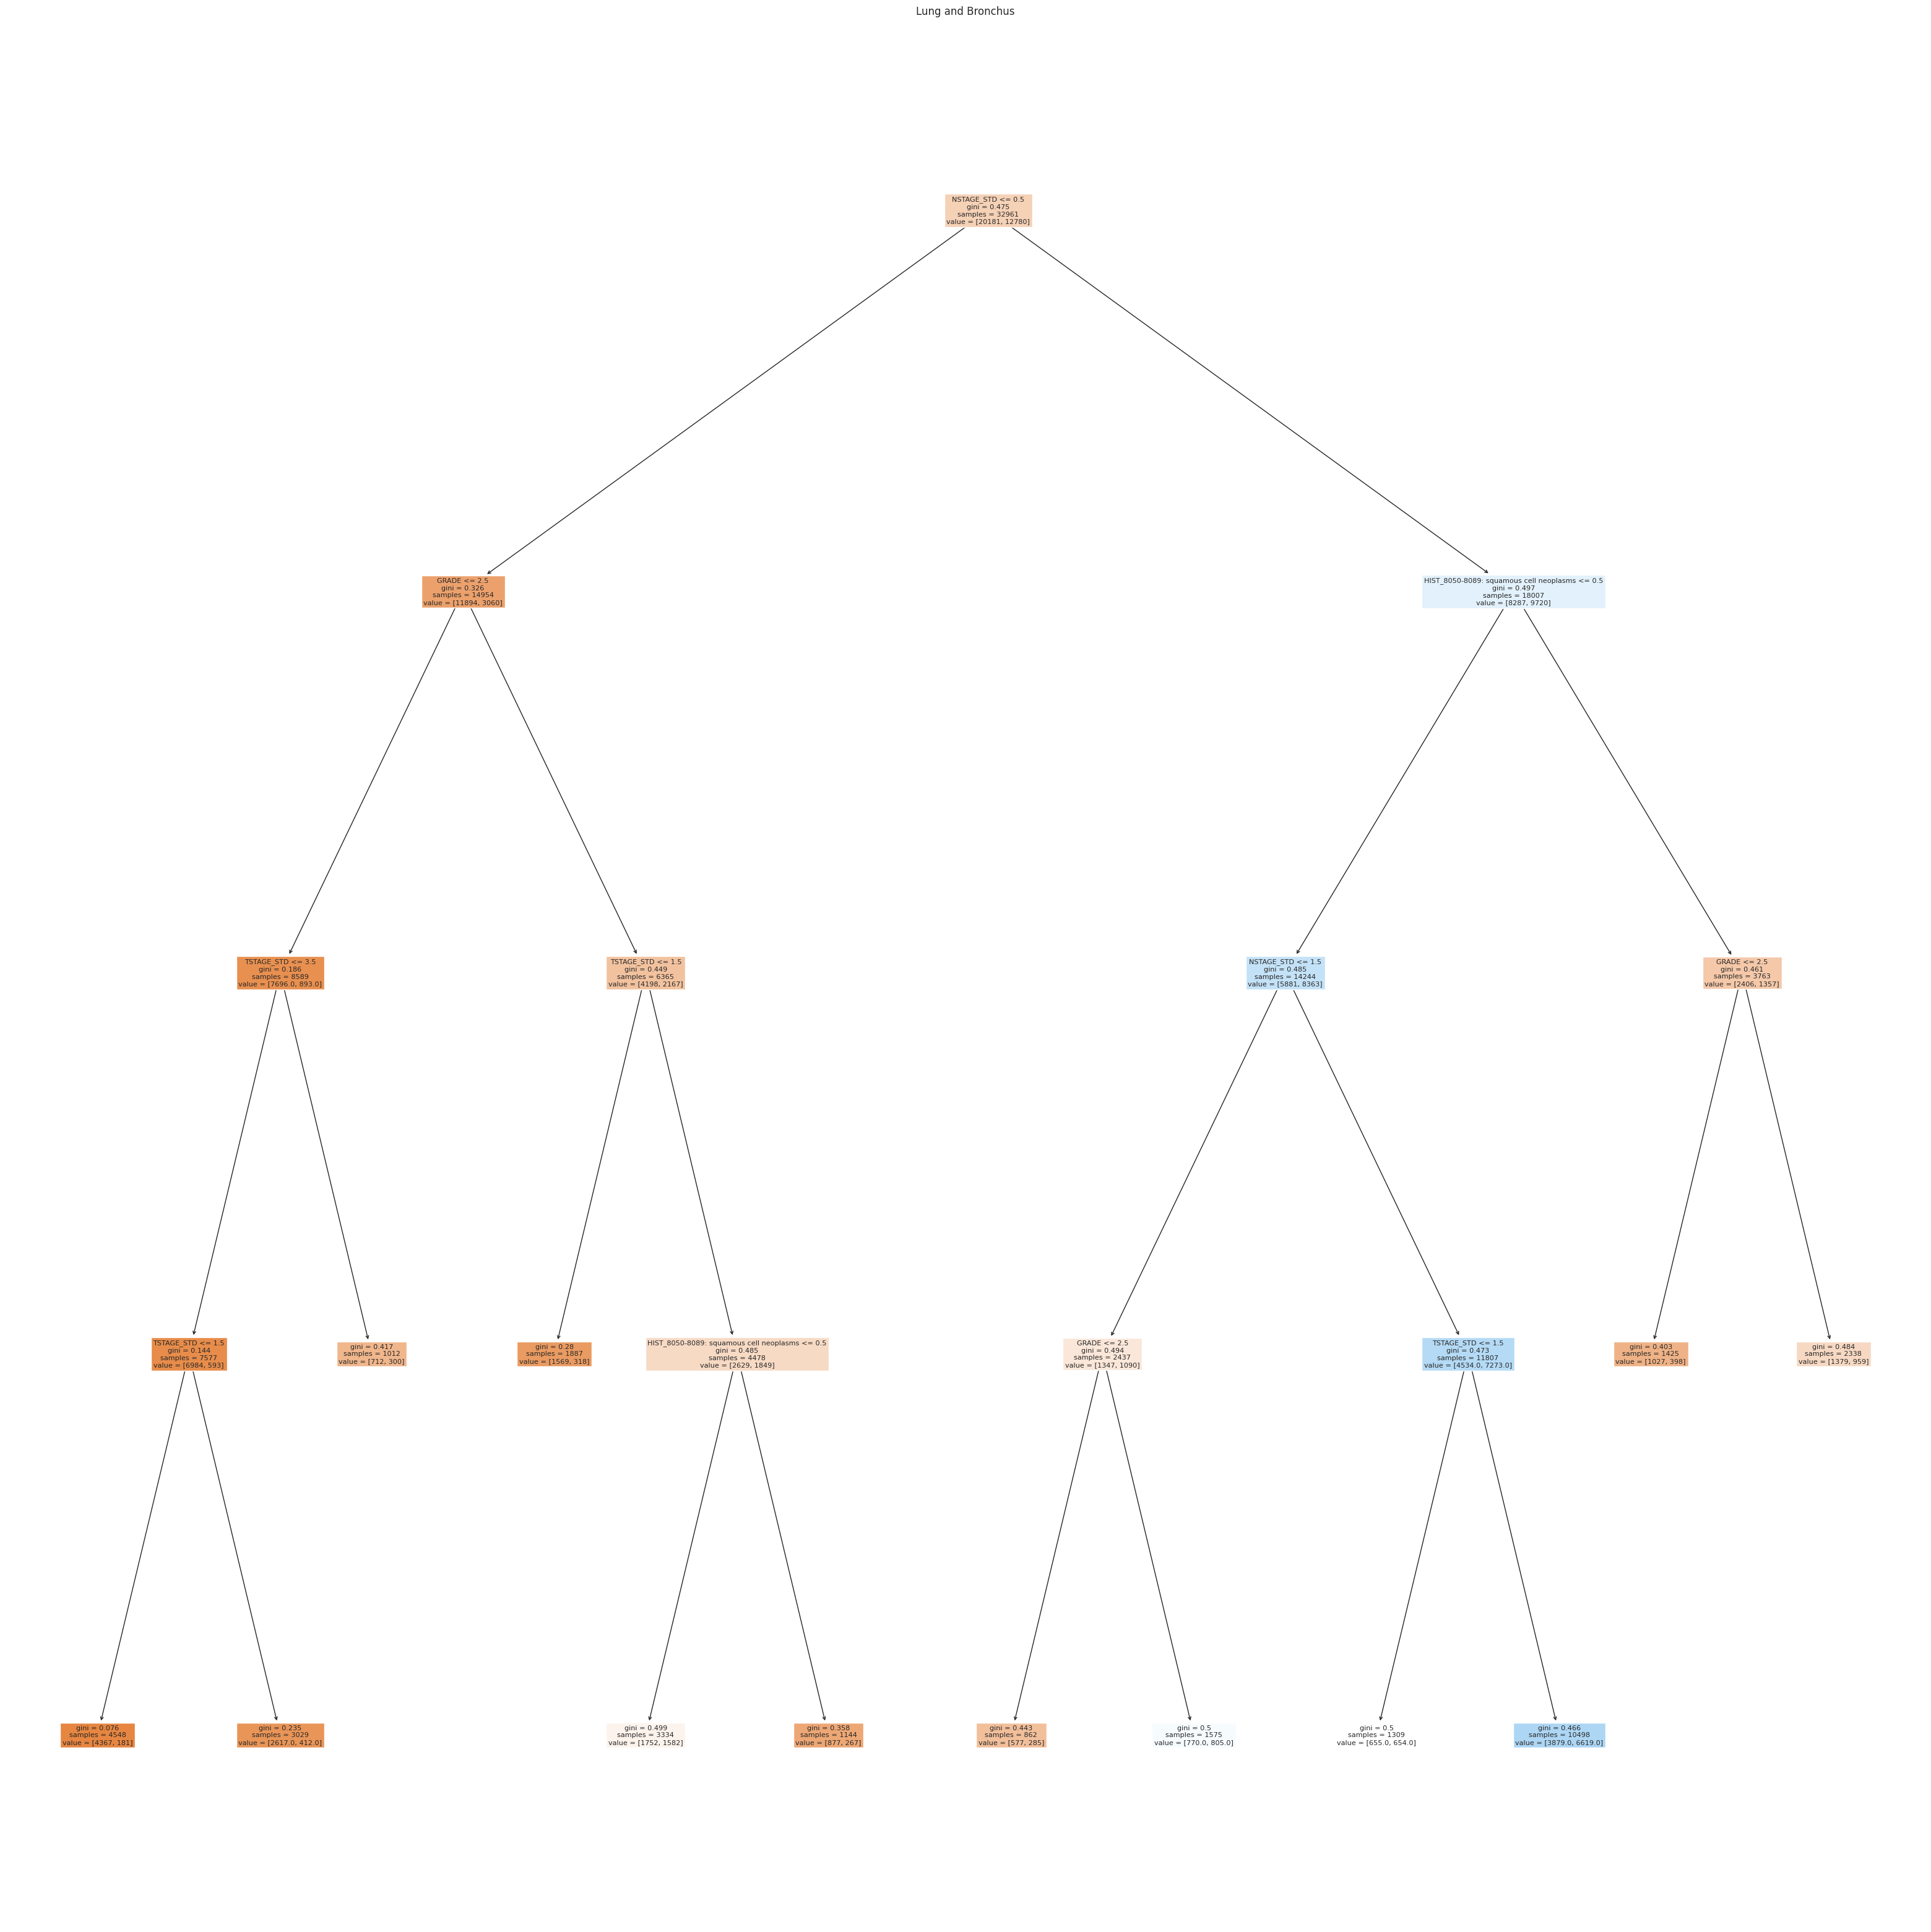

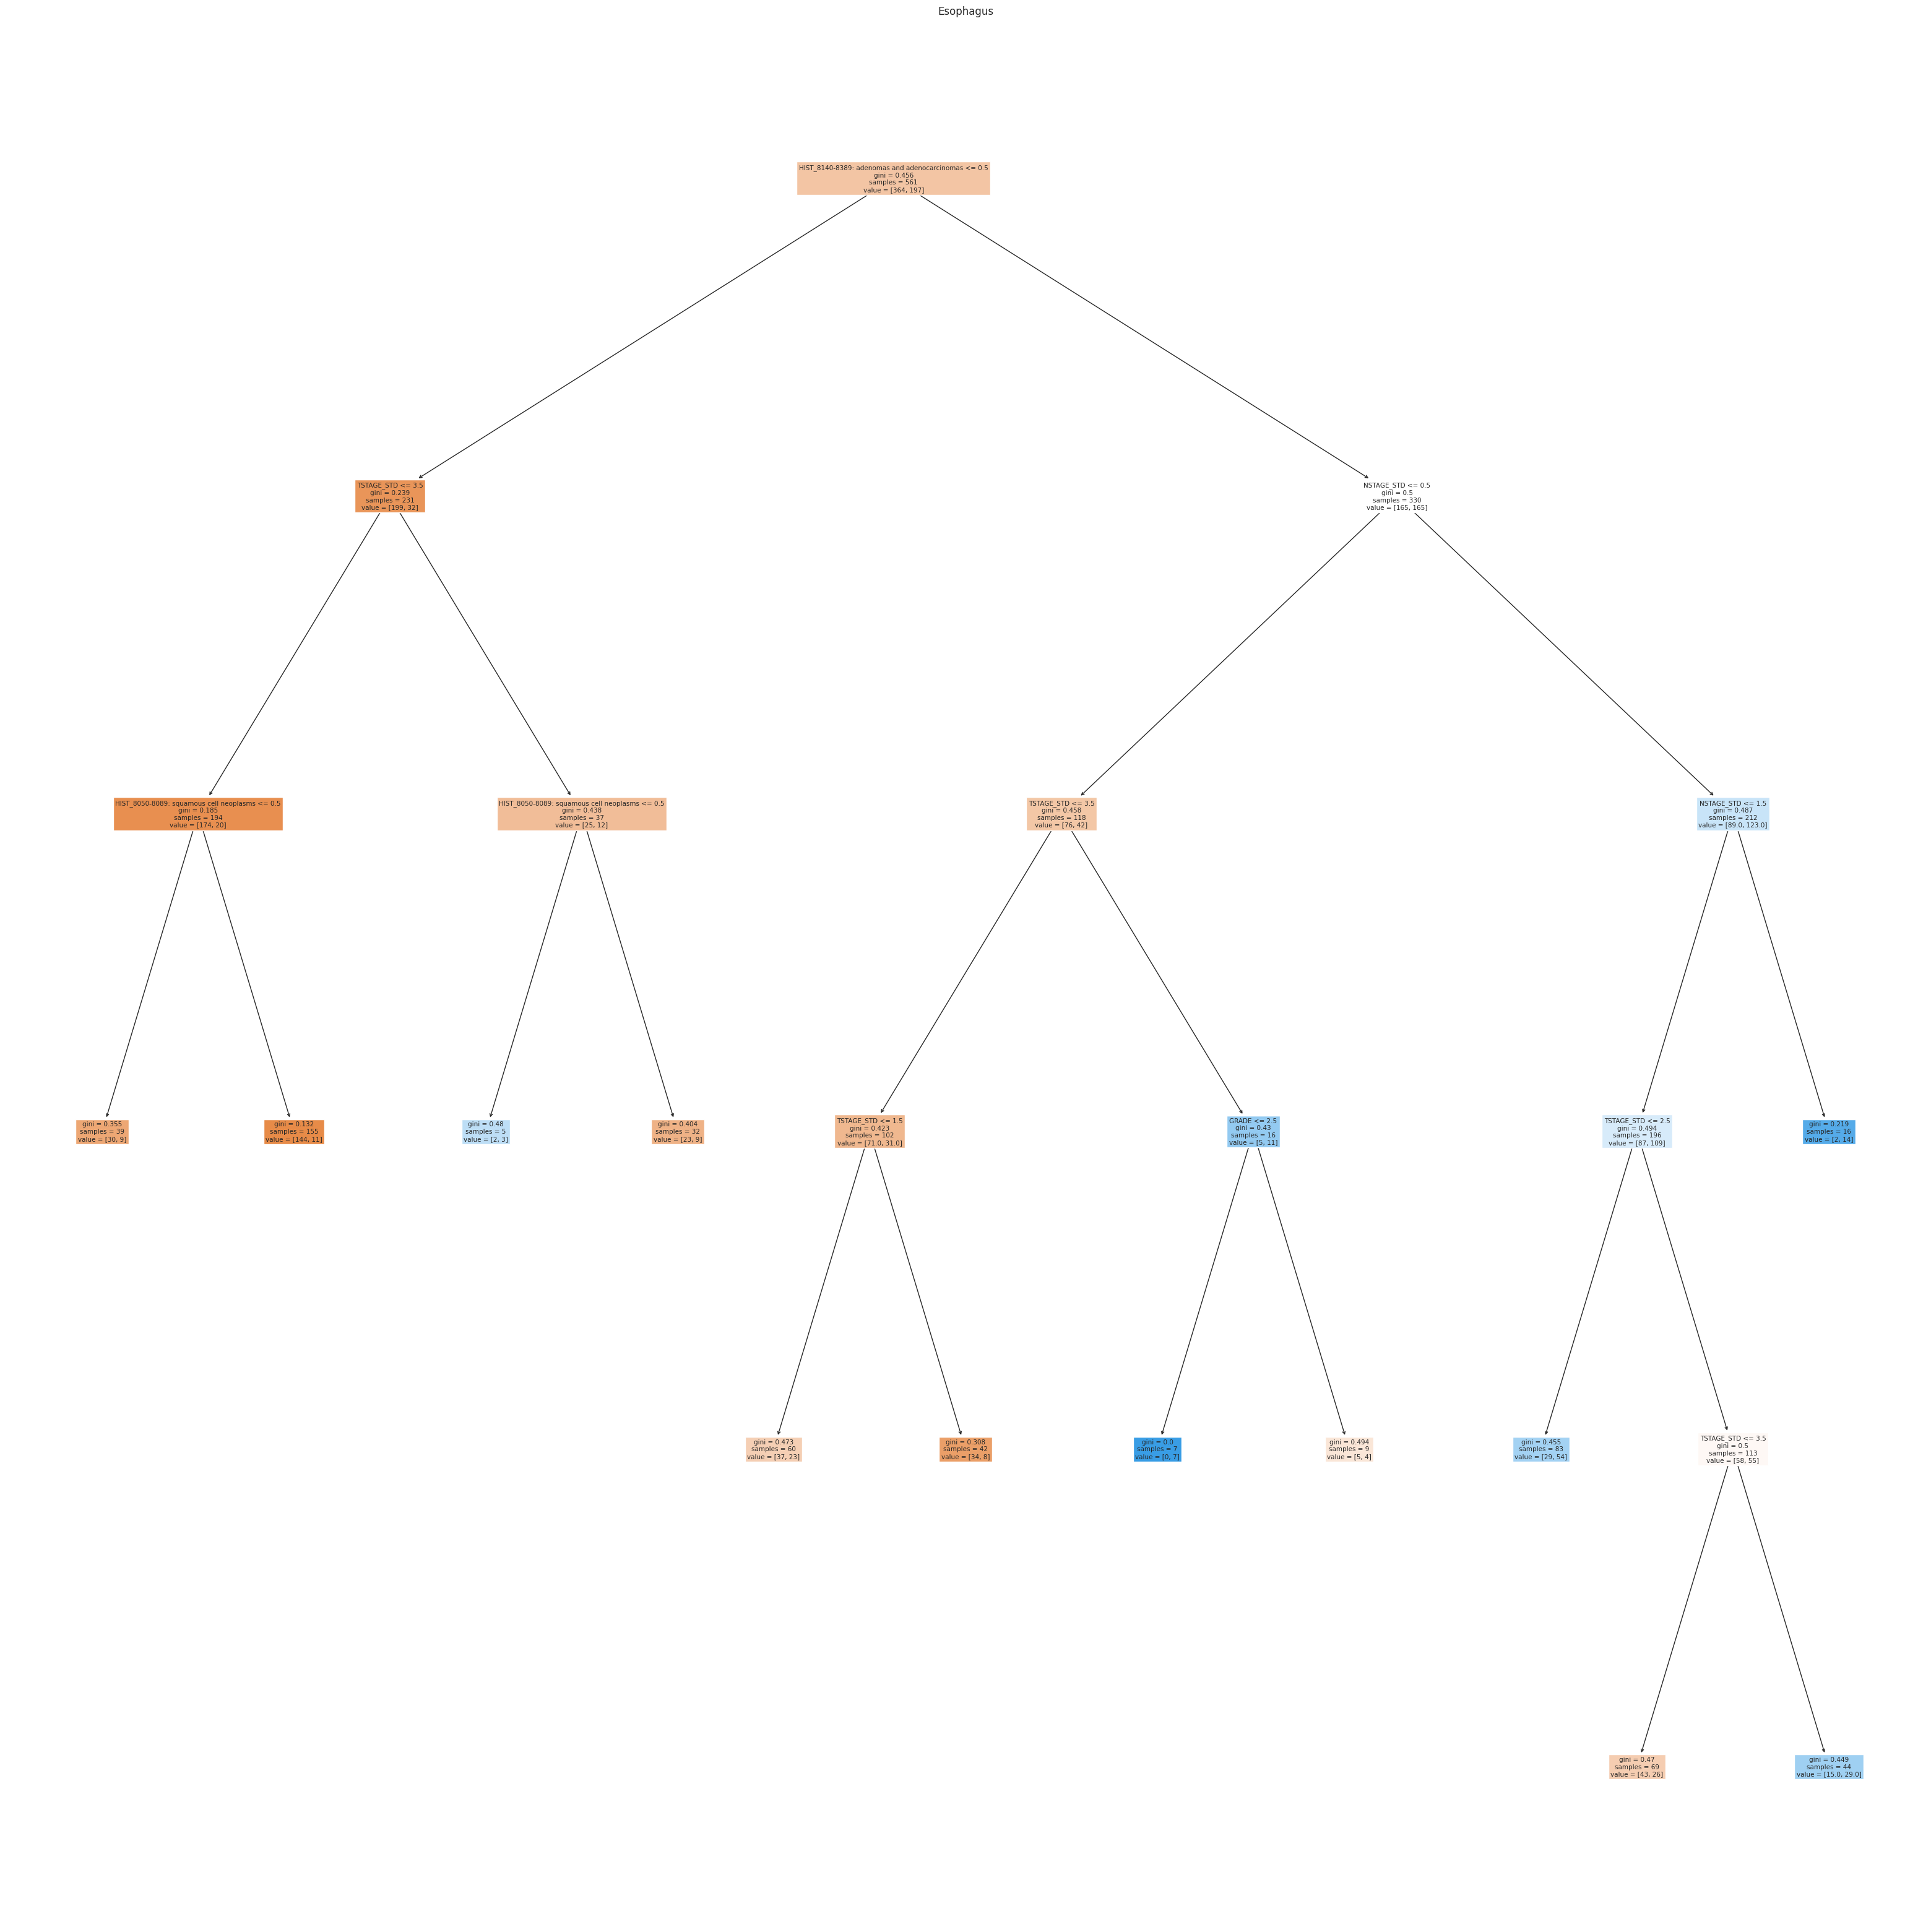

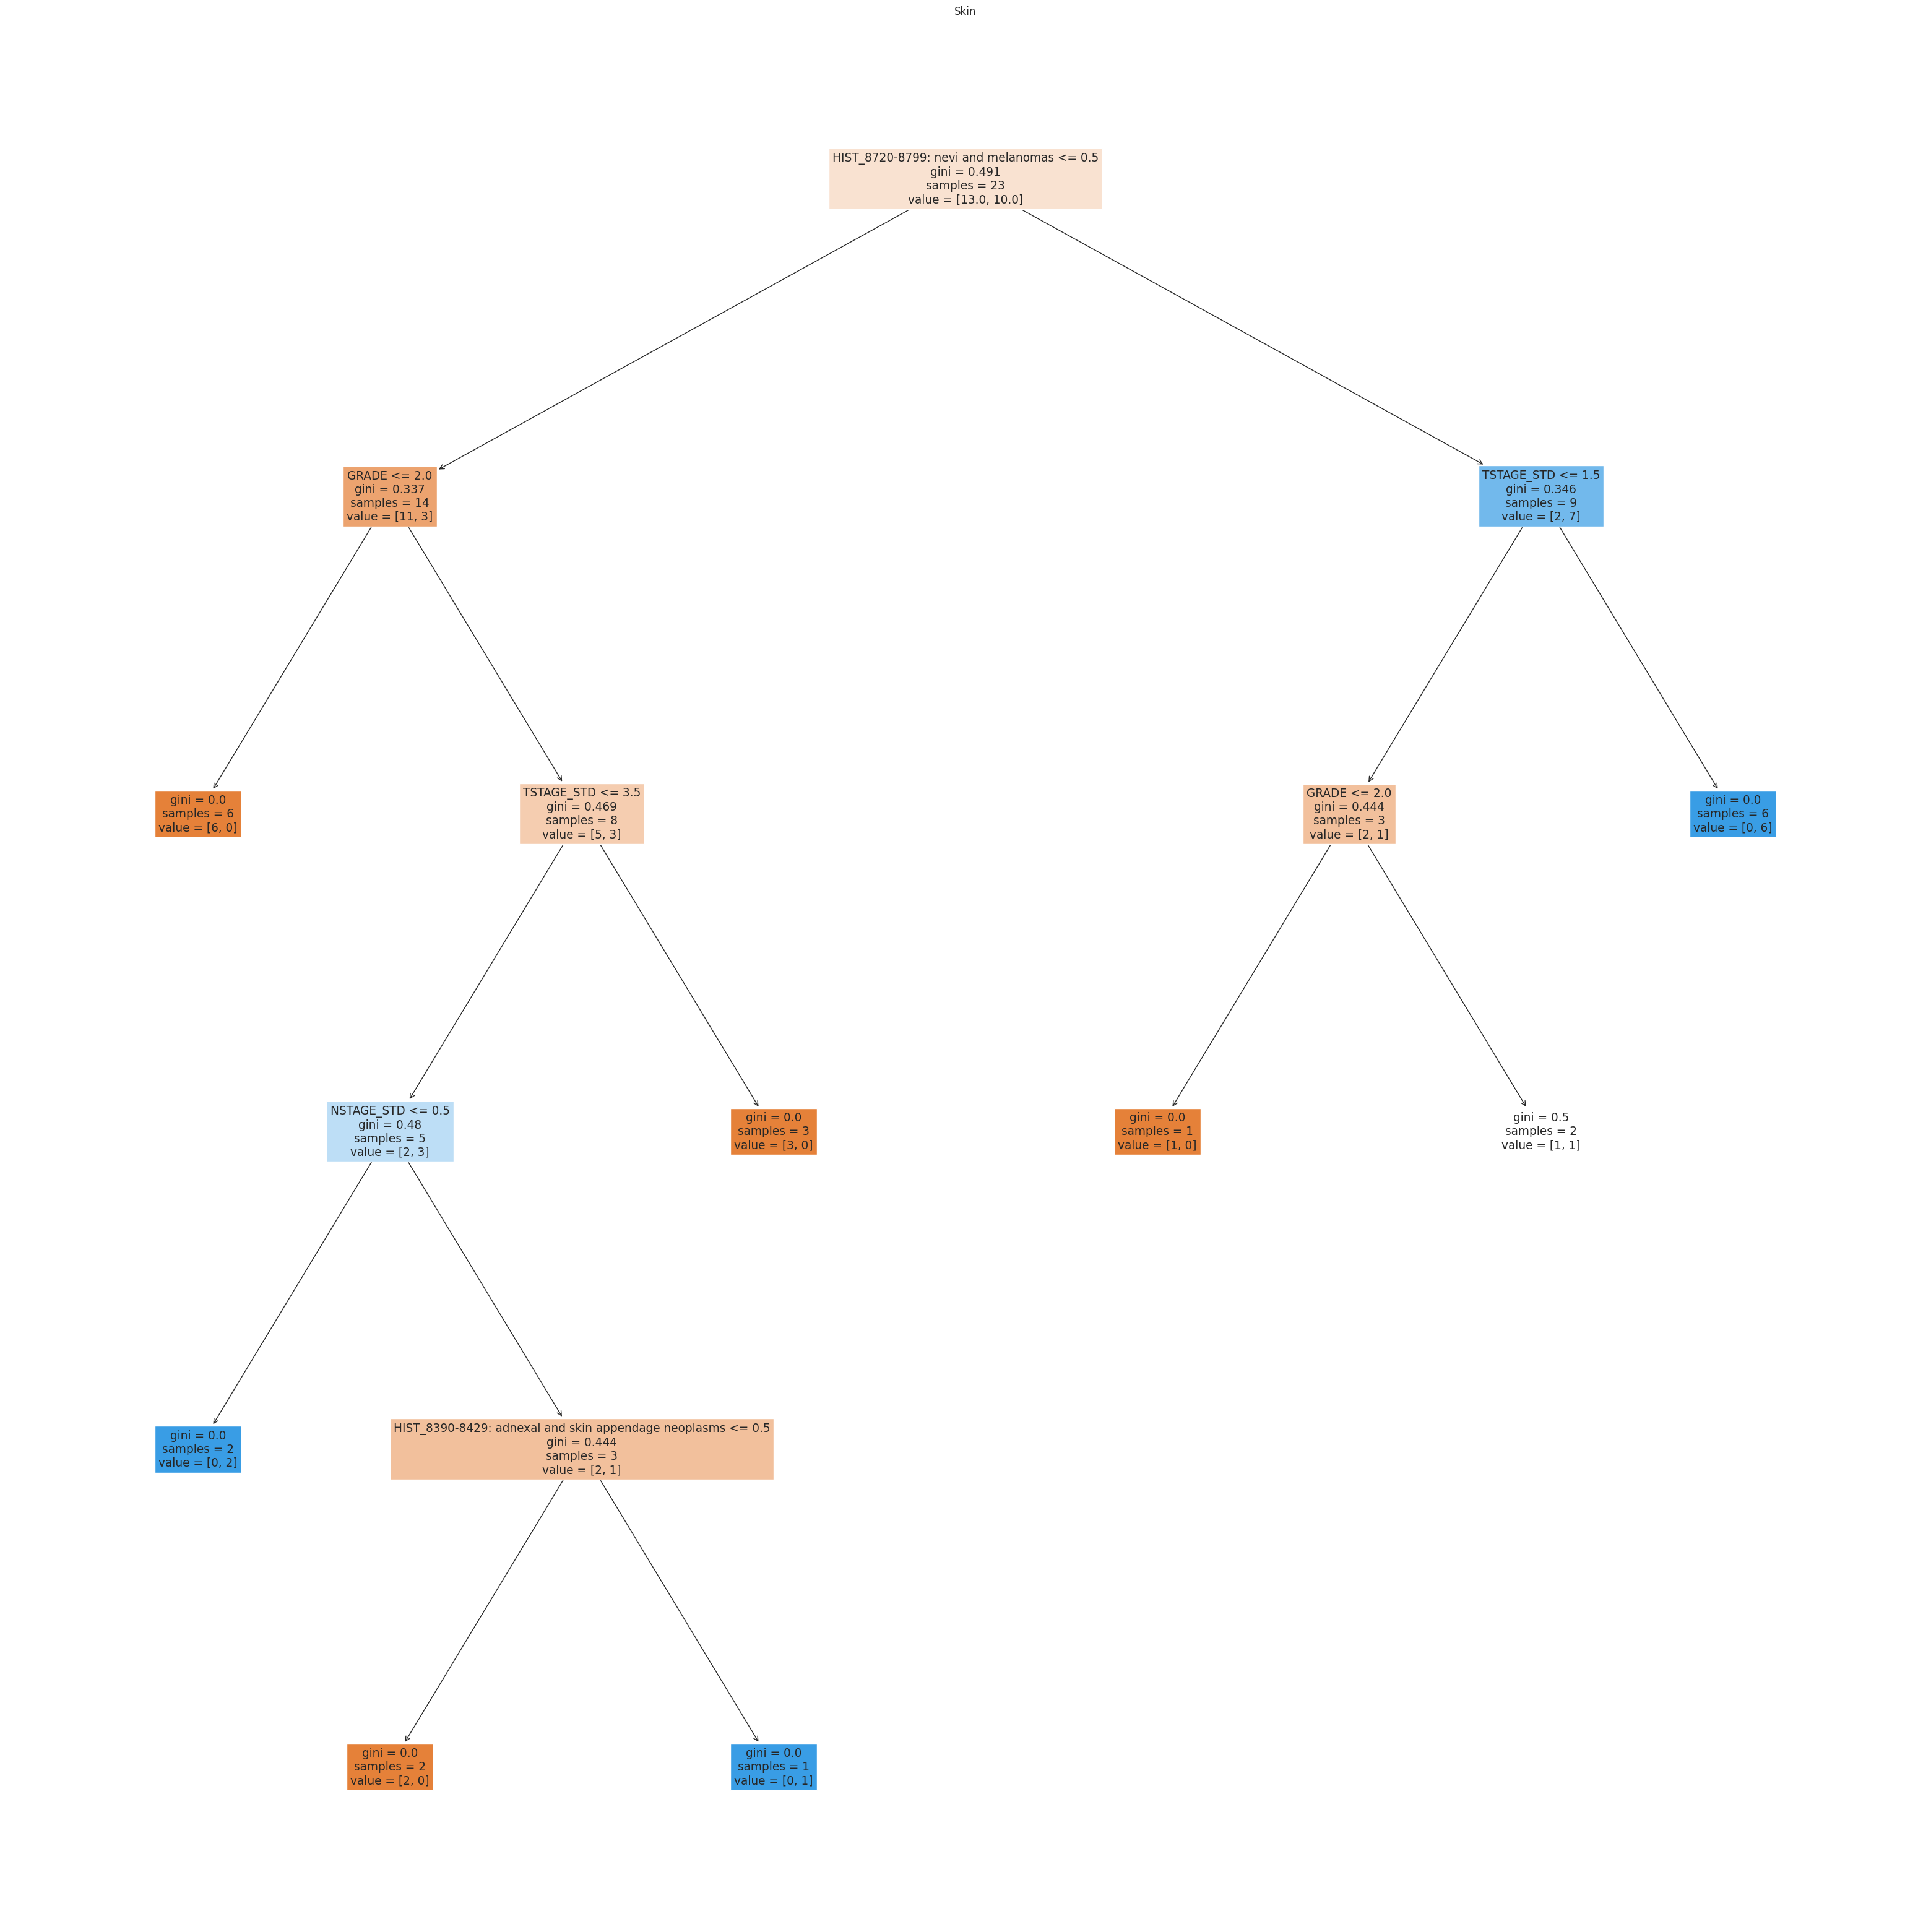

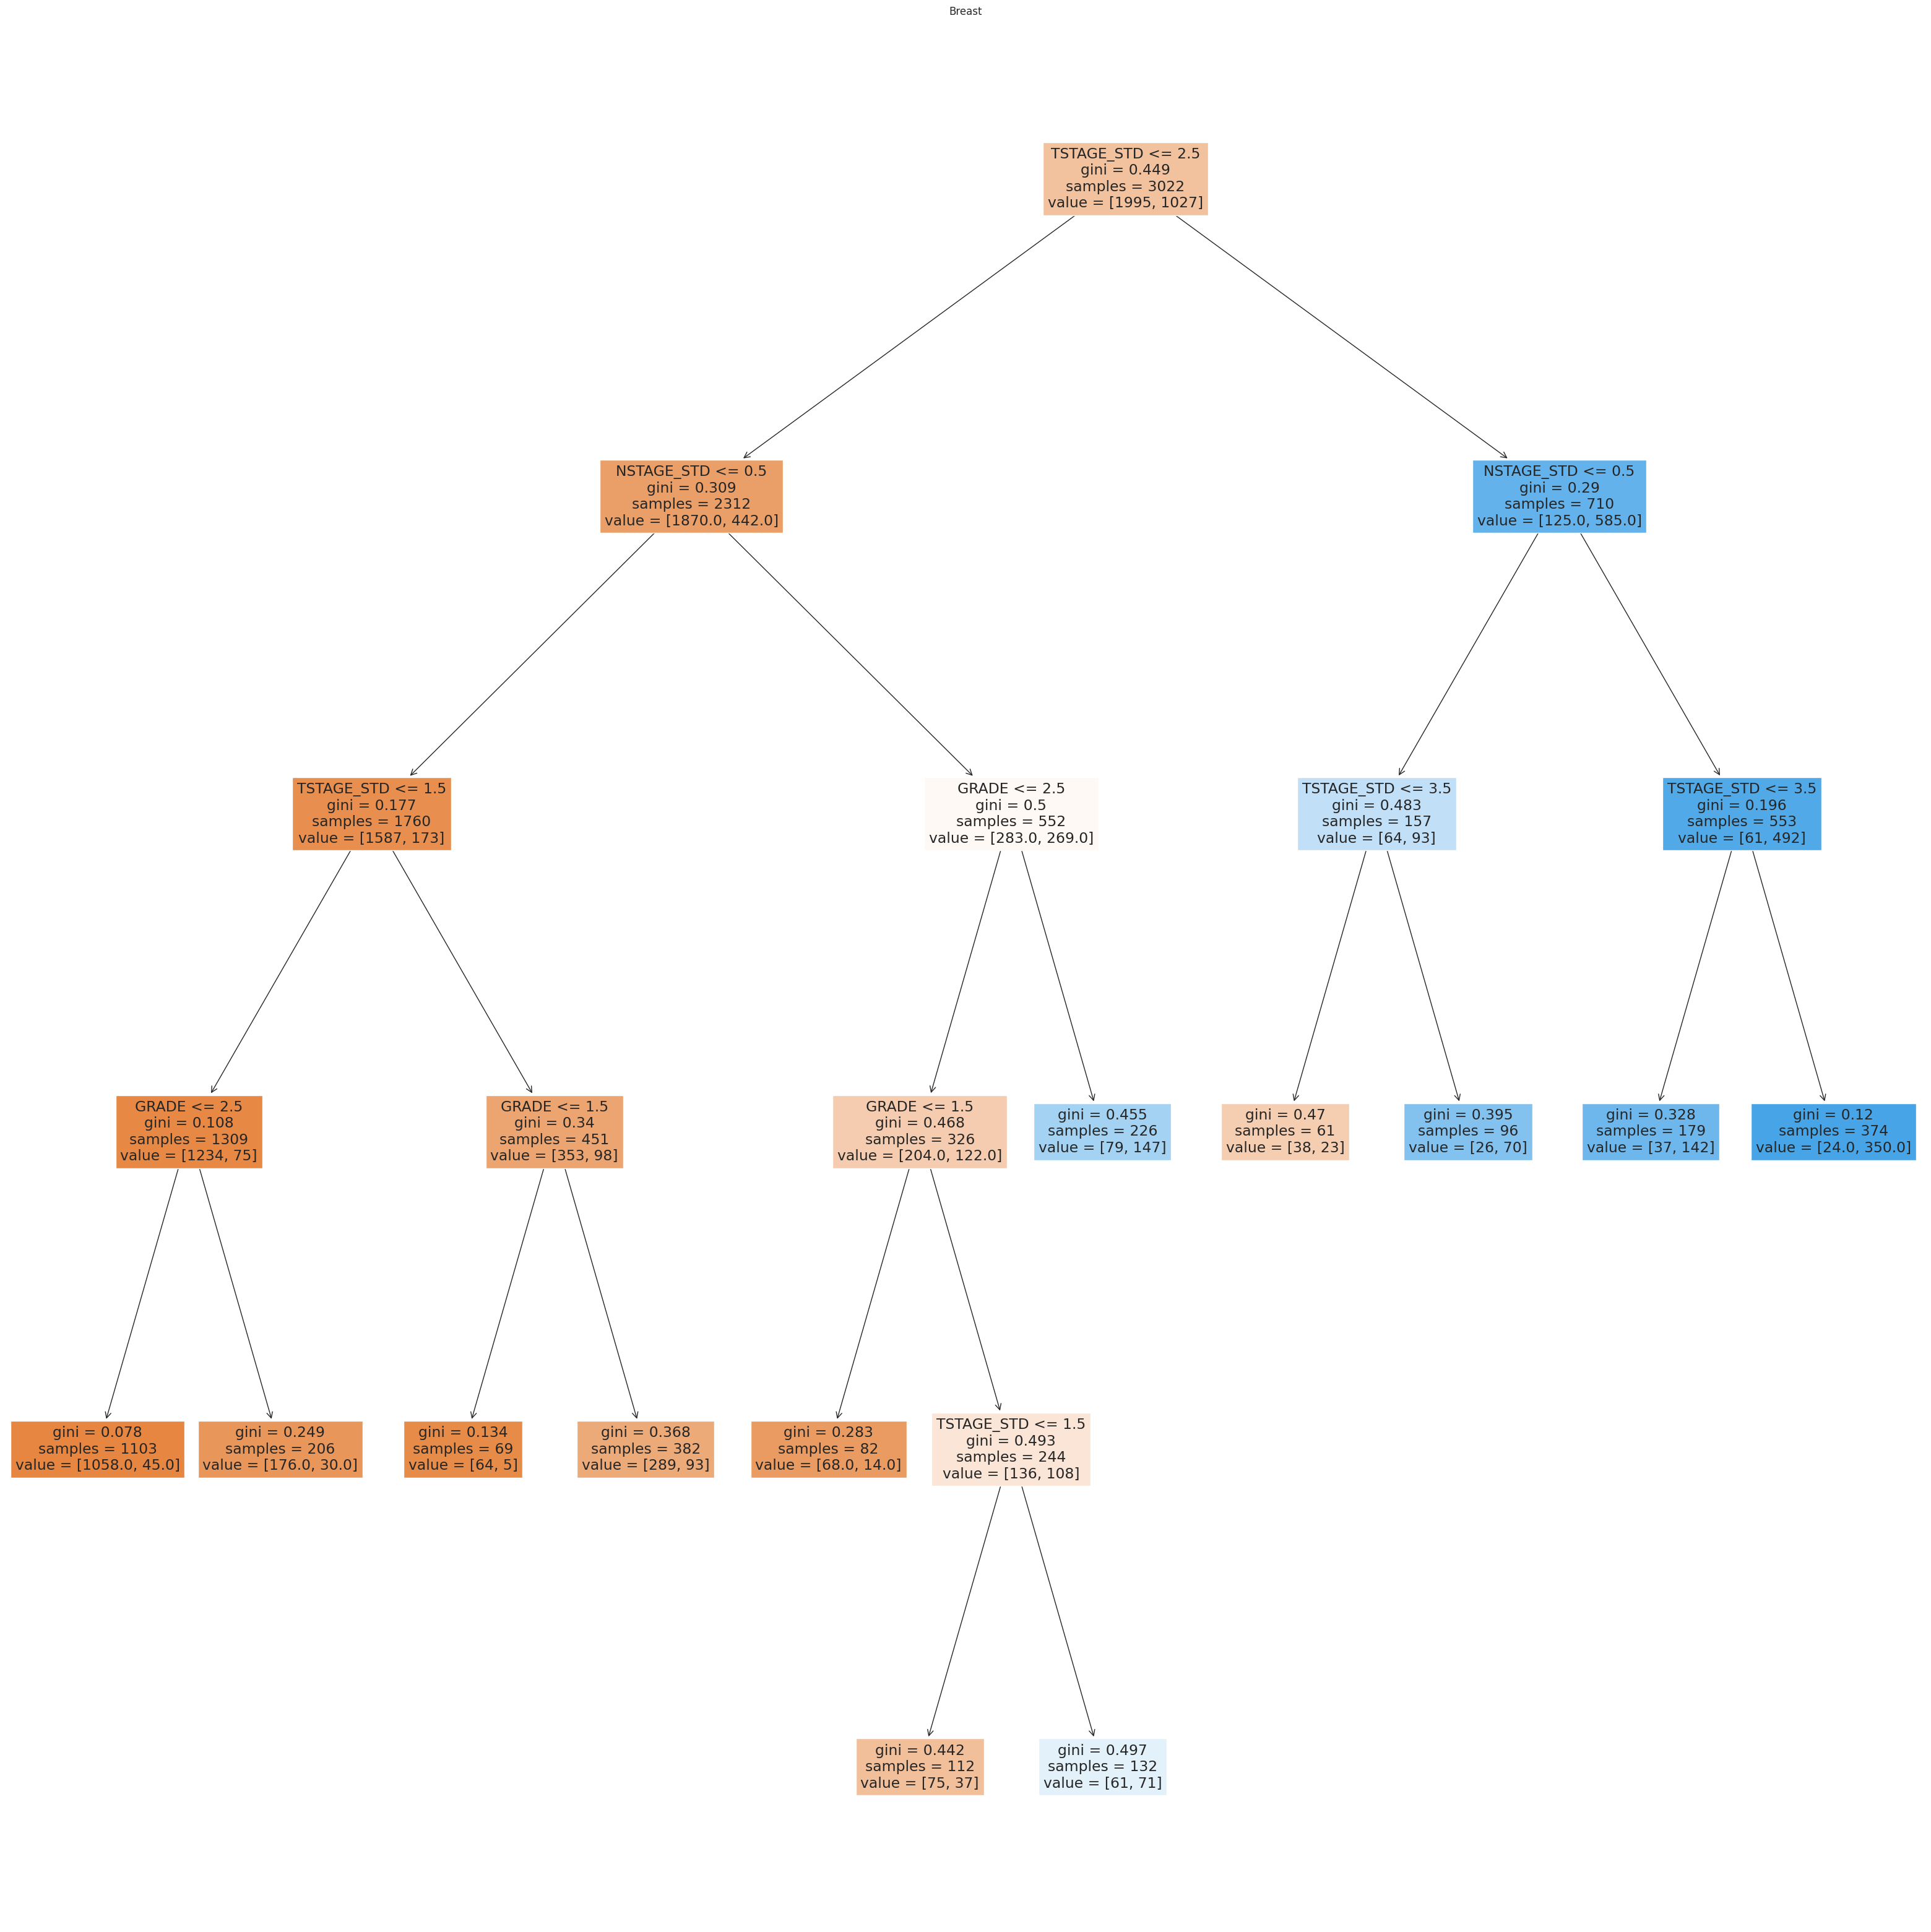

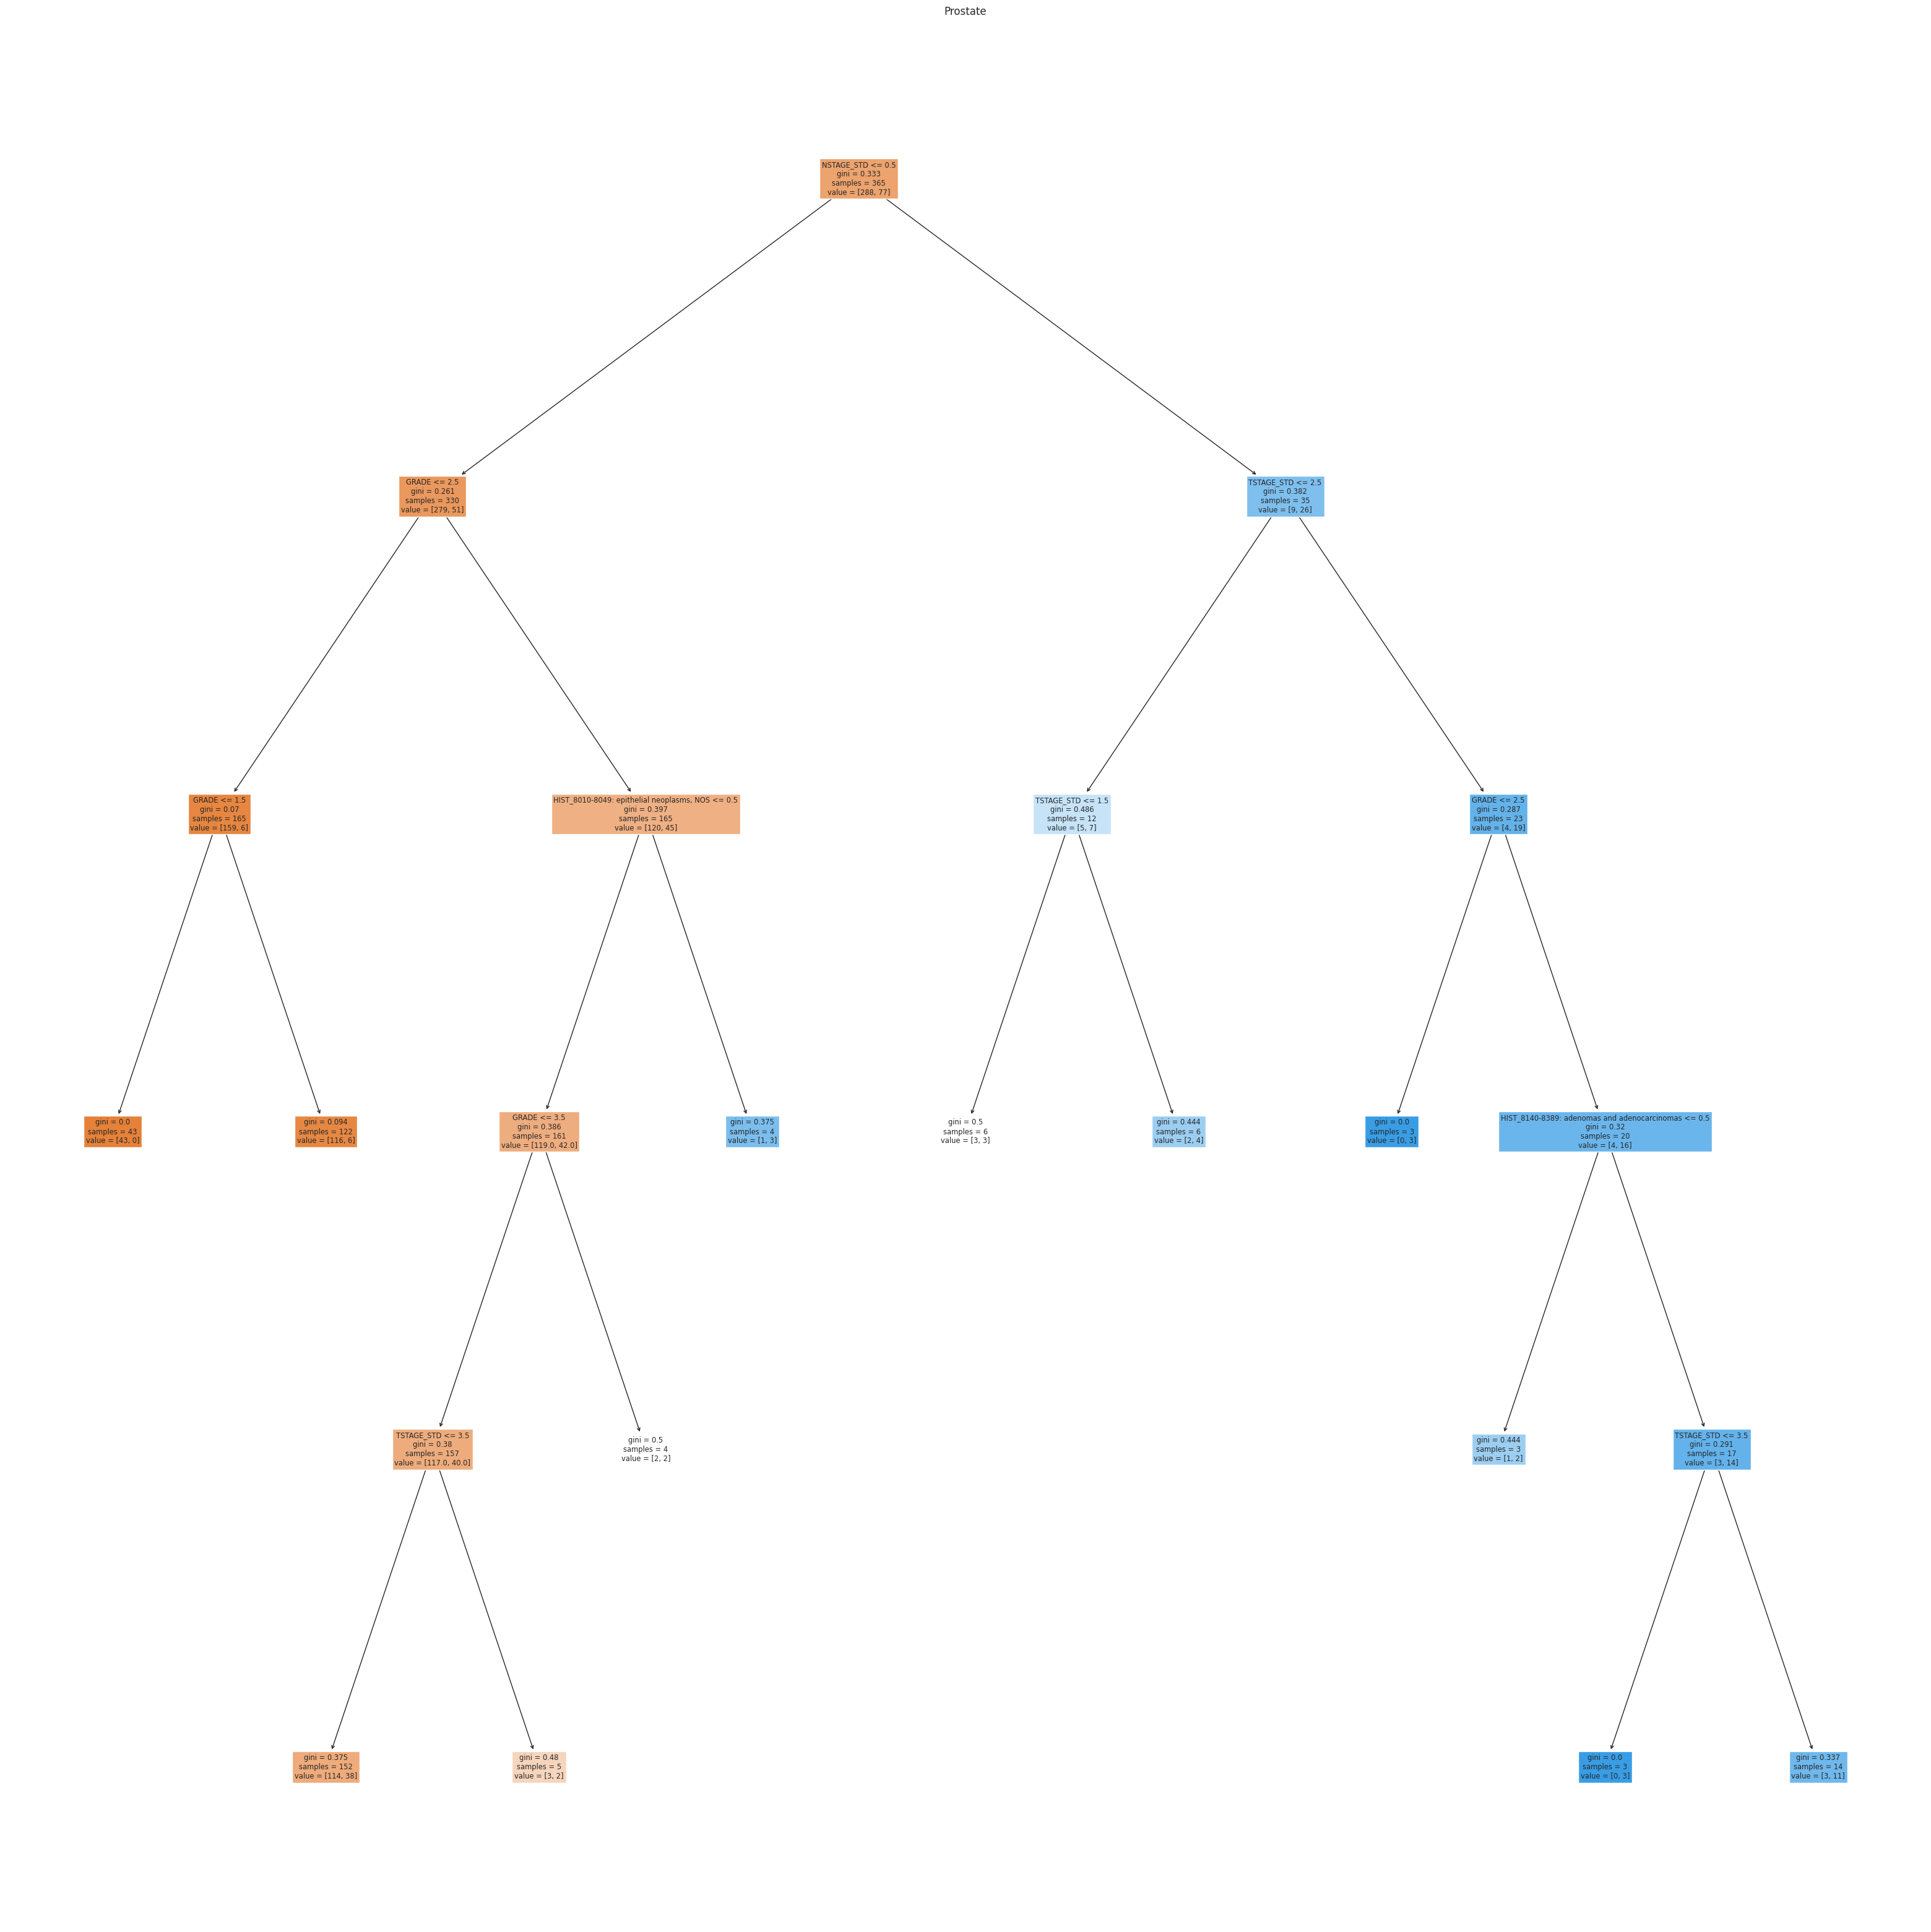

In [105]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

SITES = ['Lung and Bronchus', 'Esophagus', 'Skin', 'Breast', 'Prostate']
# SITES = ['Breast']
# FEATURES = ['TSTAGE_STD', 'NSTAGE_STD', 'GSTAGE_STD', 'GRADE', 'HISTOLOGY', 'BRAIN_MET']
# FEATURES = ['TSTAGE_STD', 'NSTAGE_STD', 'GSTAGE_STD', 'GRADE', 'BRAIN_MET']
# FEATURES = ['TSTAGE_STD', 'NSTAGE_STD', 'GSTAGE_STD', 'GRADE', 'HISTOLOGY', 'BRAIN_MET']
FEATURES = ['TSTAGE_STD', 'NSTAGE_STD', 'GRADE', 'HISTOLOGY', 'BRAIN_MET']
TARGET = 'BRAIN_MET'

DO_MI = False
DO_PCA = False
DO_DC = True

mi_df = pd.DataFrame(index=SITES, columns=FEATURES)

for site in SITES:
    print(f'\n\n --- {site} --- ')
    df = records_df.loc[records_df['SITE']==site]
    df = df[FEATURES]
    
    # Mutual Information
    if DO_MI:
        for feature in FEATURES:
            mi_stat = do_mutual_information(df, feature, TARGET)
            mi_df.loc[site, feature] = mi_stat
    
    # PCA 
    if DO_PCA or DO_DC:
        if 'TSTAGE_STD' in FEATURES:
            df['TSTAGE_STD'] = df['TSTAGE_STD'].map({'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4})
        if 'NSTAGE_STD' in FEATURES:
            df['NSTAGE_STD'] = df['NSTAGE_STD'].map({'N0': 0, 'N1': 1, 'N2': 2, 'N3': 3})
        if 'GSTAGE_STD' in FEATURES:
            df['GSTAGE_STD'] = df['GSTAGE_STD'].map({'I': 1, 'II': 2, 'III': 3, 'IV': 4})
        if 'GRADE' in FEATURES:
            df['GRADE'] = df['GRADE'].map({'G1': 1, 'G2': 2, 'G3': 3, 'G4': 4})
    
    # PCA 
    if DO_PCA:
        if 'HISTOLOGY' in FEATURES:
            le = LabelEncoder()
            df['HISTOLOGY'] = le.fit_transform(df['HISTOLOGY'])
        # print(df.head())
        embedding_df = do_pca(df)
        # print(embedding_df.head())
        plot_interactive(embedding_df, title=site, color_by='BRAIN_MET')
        df['HISTOLOGY'] = le.inverse_transform(df['HISTOLOGY'])

    # Decision Tree
    if DO_DC:
        # balancing classes
        yes_data = df.loc[df[TARGET] == 'YES']
        no_data = df.loc[df[TARGET] == 'NO'].head(yes_data.shape[0])
        df = pd.concat([yes_data, no_data], ignore_index=True)

        # category encoding
        print(f'Decision tree using {df.shape[0]} records (balanced classes).')
        if 'HISTOLOGY' in FEATURES:
            start_rows = df.shape[0]
            df = df.reset_index(drop=True)
            lb = LabelBinarizer()
            histology_df = pd.DataFrame(data=lb.fit_transform(df['HISTOLOGY']), columns=['HIST_'+ x for x in lb.classes_]) # type: ignore
            df = df.drop('HISTOLOGY', axis=1)
            df = pd.concat([df, histology_df], axis=1)
            end_rows = df.shape[0]
            assert start_rows == end_rows
        df[TARGET] = df[TARGET].map({'YES': 1, 'NO': 0})
        do_decision_tree(df, title=site, target=TARGET)



In [ ]:

pd.options.display.float_format = "{:,.2f}".format

def plot_matrix(df: pd.DataFrame) -> None:
    plt.matshow(df) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df.columns))
    plt.xticks(tick_marks, df.columns, rotation=45)
    plt.yticks(tick_marks, df.index)
    #plt.tight_layout()
    plt.ylabel(df.index.name)
    plt.xlabel(df.columns.name)

mi_df = mi_df.apply(pd.to_numeric)
mi_norm_df = mi_df.apply(lambda x: x/x.max(), axis=1)
# print(mi_df)
# print(mi_norm_df)

plot_matrix(mi_df)
plot_matrix(mi_norm_df)





In [ ]:


# X_test = X.head(1).to_numpy()
# feature = clf.tree_.feature
# threshold = clf.tree_.threshold

# node_indicator = clf.decision_path(X_test)
# leaf_id = clf.apply(X_test)

# sample_id = 0
# # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
# node_index = node_indicator.indices[
#     node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
# ]

# print("Rules used to predict sample {id}:\n".format(id=sample_id))
# for node_id in node_index:
#     # continue to the next node if it is a leaf node
#     if leaf_id[sample_id] == node_id:
#         continue

#     # check if value of the split feature for sample 0 is below threshold
#     if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
#         threshold_sign = "<="
#     else:
#         threshold_sign = ">"

#     print(
#         "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
#         "{inequality} {threshold})".format(
#             node=node_id,
#             sample=sample_id,
#             feature=feature[node_id],
#             value=X_test[sample_id, feature[node_id]],
#             inequality=threshold_sign,
#             threshold=threshold[node_id],
#         )
#     )


In [ ]:

from sklearn.preprocessing import LabelBinarizer
# data = df.head(10000)
df = df[['site', 'TSTAGE_STD', 'NSTAGE_STD', 'GSTAGE_STD', 'grade', 'brain_met']]
df = df[['site', 'TSTAGE_STD', 'NSTAGE_STD', 'GSTAGE_STD', 'grade', 'brain_met']]
df = df.dropna()
df = df.reset_index(drop=True)
print(f'Using {df.shape[0]} records.')
lb = LabelBinarizer()
tstage_df = pd.DataFrame(data=lb.fit_transform(df['TSTAGE_STD']), columns=lb.classes_) # type: ignore
site_df = pd.DataFrame(data=lb.fit_transform(df['site']), columns=lb.classes_) # type: ignore
full_df = pd.concat([tstage_df, site_df, df['brain_met']], axis=1)

X = full_df.drop('brain_met', axis=1)
Y = full_df['brain_met']

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X, Y)

from sklearn.tree import plot_tree
fig = plt.figure(figsize=(40, 40))
_ = plot_tree(clf, feature_names=X.columns.to_list(), filled=True)



---------------

## Patient-Level Analysis 



----------

#### Prevalence

The proportion of all people in the study population who have the outcome of interest (e.g., disease or condition) at a particular time



In [7]:
MIN_RECORDS_PER_SITE = 10000

In [8]:
####################
# Records per site #
####################

# simple value counts (ie num records per site)
df = deepcopy(master)
total_df = df['SITE'].value_counts()
total_df = total_df.reset_index()
total_df.columns = ['SITE', 'count']
total_df = total_df.sort_values(by=['count'], ascending=False)

# filtering & defining common sort order
total_df = total_df.loc[total_df['count'] > MIN_RECORDS_PER_SITE]  # filter low count sites 

# to ensure proper order and colors for following plots
site_map = {site: idx + 1 for idx, site in zip(total_df.index, total_df['SITE'])}
site_map['Total'] = 0
all_sites = set(total_df['SITE'].to_list())
common_cmap = {site: col for site, col in zip(all_sites, itertools.cycle(sns.color_palette('muted', as_cmap=True)))}

#############################
# BM prevalence (2010-2020) #
#############################

# total prevalence (ie num records marked as possessing BrainMet)
data = []
bm_count = df['BRAIN_MET'].value_counts()['YES']
print(f'Total prevalence: {(bm_count/df.shape[0]) * 100:0.1f} in 100 people')
data.append(['Total', bm_count, bm_count/df.shape[0]])

# site prevalence (as above, but per site. last site only)
df = df[['SITE', 'BRAIN_MET']]
counts = df.groupby('SITE').value_counts(sort=True, ascending=False)
for site in all_sites:
    has_bm = 0 if 'YES' not in counts[site] else counts[site]['YES']
    no_bm = 0 if 'NO' not in counts[site] else counts[site]['NO']
    data.append([site, has_bm, has_bm/(has_bm+no_bm)])
print(data)


Total prevalence: 1.4 in 100 people
[['Total', 76591, 0.014418429445214919], ['Urinary Bladder', 233, 0.0011861852689026005], ['Larynx', 19, 0.0005859134081657826], ['Cranial Nerves Other Nervous System', 36, 0.0002702763575756211], ['Leukemia', 2, 1.3818548637836568e-05], ['Soft Tissue including Heart', 219, 0.006258573388203018], ['Ovary', 158, 0.0025965062201114197], ['Breast', 2965, 0.003437091374465599], ['Brain', 376, 0.005177850916452071], ['Testis', 246, 0.008979413053000438], ['Other Endocrine including Thymus', 123, 0.0020339655714120353], ['Small Intestine', 66, 0.0026453966090825283], ['Gallbladder', 55, 0.004401760704281713], ['Miscellaneous', 1348, 0.007969493629725976], ['Colorectal', 1077, 0.0026214010500208106], ['Eye and Orbit', 26, 0.0025742574257425744], ['Myeloma', 0, 0.0], ['Anus, Anal Canal and Anorectum', 23, 0.0007490148826000586], ['Kidney and Renal Pelvis', 2343, 0.01351094196003806], ['Intrahepatic Bile Duct', 50, 0.0036713415081870916], ['Other Biliary', 66

['Anus, Anal Canal and Anorectum', 'Brain', 'Breast', 'Cervix', 'Colorectal', 'Cranial Nerves Other Nervous System', 'Esophagus', 'Eye and Orbit', 'Gallbladder', 'Hodgkin Lymphoma', 'Intrahepatic Bile Duct', 'Kidney and Renal Pelvis', 'Larynx', 'Leukemia', 'Liver', 'Lung and Bronchus', 'Miscellaneous', 'Mouth', 'Myeloma', 'Non-Hodgkin Lymphoma', 'Other Biliary', 'Other Endocrine including Thymus', 'Other Female Genital Organs', 'Ovary', 'Pancreas', 'Prostate', 'Skin', 'Small Intestine', 'Soft Tissue including Heart', 'Stomach', 'Testis', 'Throat', 'Thyroid', 'Total', 'Urinary Bladder', 'Uterus', 'Vulva']
['Anus, Anal Canal and Anorectum', 'Brain', 'Breast', 'Cervix', 'Colorectal', 'Cranial Nerves Other Nervous System', 'Esophagus', 'Eye and Orbit', 'Gallbladder', 'Hodgkin Lymphoma', 'Intrahepatic Bile Duct', 'Kidney and Renal Pelvis', 'Larynx', 'Leukemia', 'Liver', 'Lung and Bronchus', 'Miscellaneous', 'Mouth', 'Myeloma', 'Non-Hodgkin Lymphoma', 'Other Biliary', 'Other Endocrine includ

<Axes: title={'center': 'BrainMet prevalence per site (percentage %)'}, xlabel='SITE', ylabel='prevalence'>

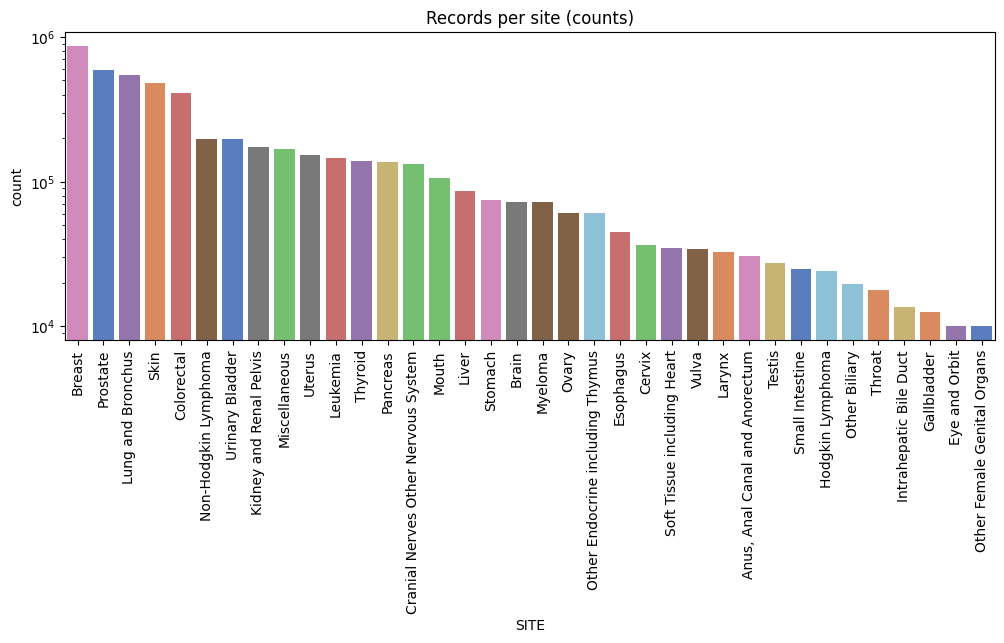

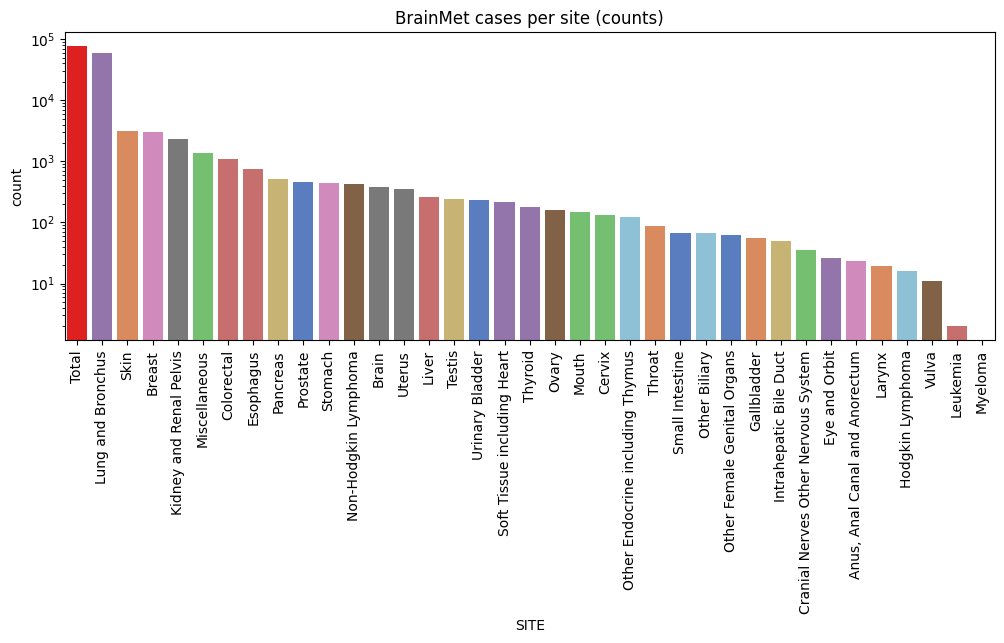

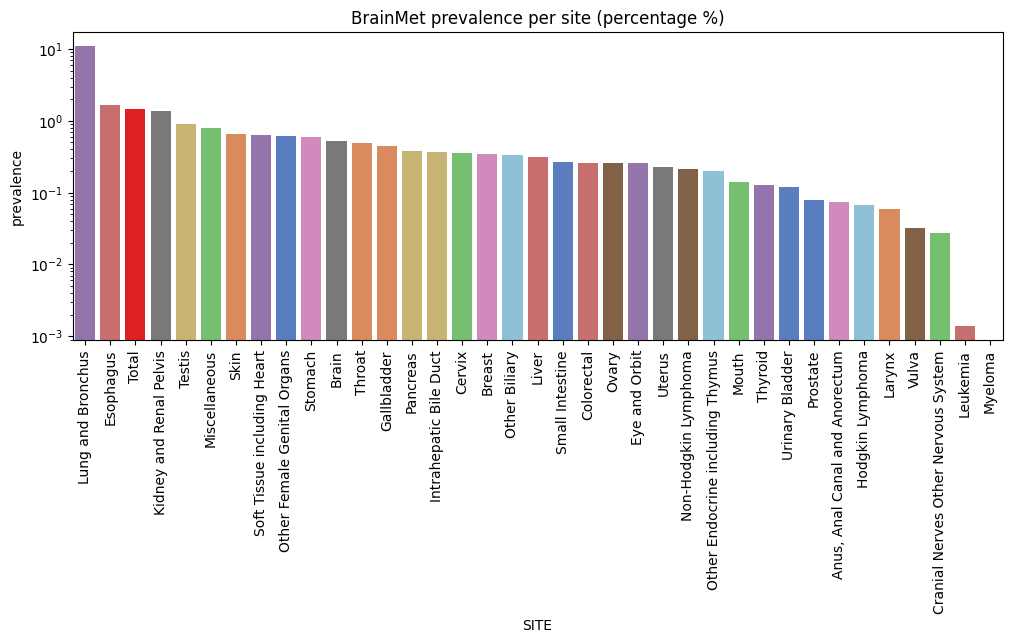

In [9]:

prev_df = pd.DataFrame(columns=['SITE', 'count', 'prevalence'], data=data)
print(sorted(prev_df['SITE'].to_list()))
print(sorted(list(site_map.keys())))
assert set(prev_df['SITE'].to_list()) == set(list(site_map.keys()))
# # sorting
# get_pos = lambda x: site_map[x]
# prev_df['position'] = prev_df['site'].apply(get_pos)
# prev_df = prev_df.sort_values(by='position', ascending=True)    
# display as percent
prev_df['prevalence'] = prev_df['prevalence'] * 100                     

# plot total counts
plt.figure(figsize=(12, 4), dpi=100)
plt.title('Records per site (counts)')
plt.xticks(rotation=90)
sns.barplot(total_df, x='SITE', y='count', palette=common_cmap, log=True)

# plot BM counts
prev_df = prev_df.sort_values(by='count', ascending=False)  
plt.figure(figsize=(12, 4), dpi=100)
another_cmap = deepcopy(common_cmap)
another_cmap['Total'] = '#FF0000'
plt.title('BrainMet cases per site (counts)')
plt.xticks(rotation=90)
sns.barplot(prev_df, x='SITE', y='count', palette=another_cmap, log=True)

# plot BM prevalence
prev_df = prev_df.sort_values(by='prevalence', ascending=False)  
plt.figure(figsize=(12, 4), dpi=100)
plt.title('BrainMet prevalence per site (percentage %)')
plt.xticks(rotation=90)
sns.barplot(prev_df, x='SITE', y='prevalence', palette=another_cmap, log=True)

# note prostate, breast, esophagus

----------

#### Odds

A single point in time.

**Odds** <br>
The probability that an event occurs divided by the probability that the event does not occur.

**Odds ratio**<br>
Ratio ie proportional odds. 



GRADE   BRAIN_MET
G1      NO            481143
        YES              766
G2      NO           1044401
        YES             4568
G3      NO            734333
        YES            12232
G4      NO            179529
        YES             2052
T_CELL  NO            262169
        YES              188
Name: count, dtype: int64
   grade proportion
G1    G1   0.158951
G2    G2   0.435475
G3    G3   1.638437
G4    G4   1.130074
GRADE  BRAIN_MET
G1     NO           27005
       YES            549
G2     NO           68808
       YES           3215
G3     NO           81714
       YES           9913
G4     NO            8642
       YES           1330
Name: count, dtype: int64

Lung and Bronchus
GRADE  BRAIN_MET
G1     NO           27005
       YES            549
G2     NO           68808
       YES           3215
G3     NO           81714
       YES           9913
G4     NO            8642
       YES           1330
Name: count, dtype: int64
   grade proportion
G1    G1   1.992451
G2   

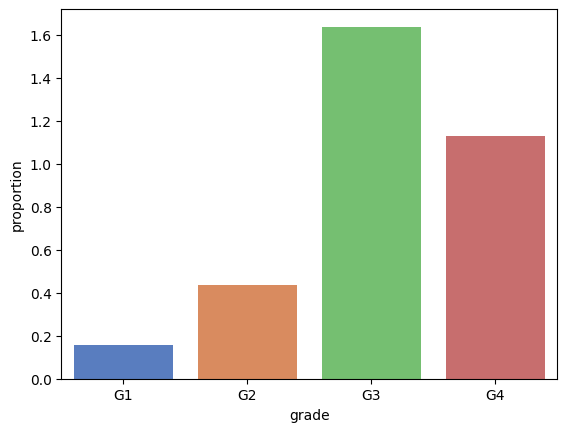

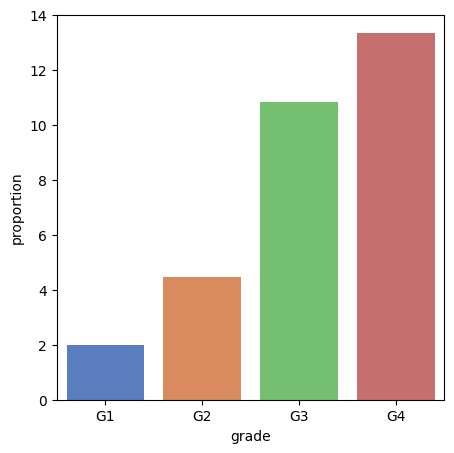

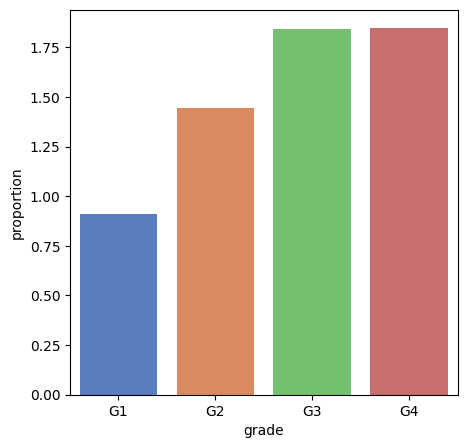

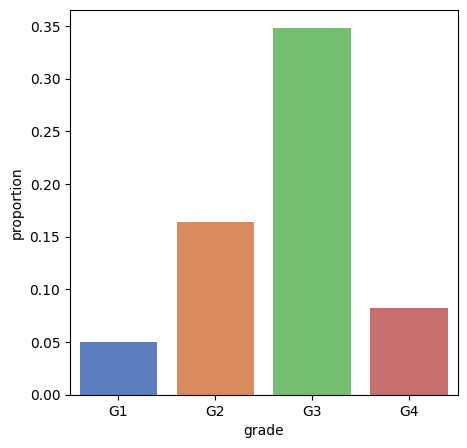

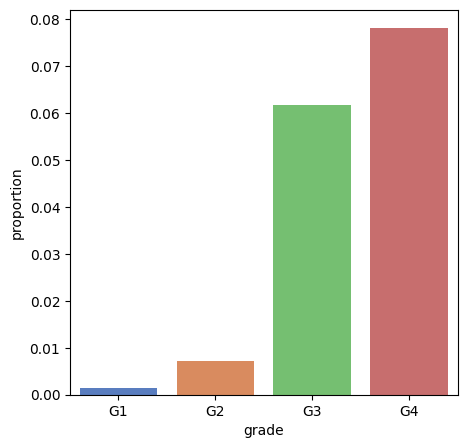

In [24]:
# Grade
df = deepcopy(master)
df = df[['SITE', 'GRADE', 'BRAIN_MET']]
grade_df = df[['GRADE', 'BRAIN_MET']]
# grade_df['last_grade'] = grade_df['grades'].apply(get_last)
# grade_df = grade_df[["last_grade", "bm_status"]]
grade_df = grade_df.groupby("GRADE").value_counts()

print(grade_df)
props = pd.DataFrame(columns=['grade', 'proportion'])
for cat in ['G1', 'G2', 'G3', 'G4']:
    cat_prop = grade_df[cat]['YES']/(grade_df[cat]['YES']+grade_df[cat]['NO']) * 100
    props.loc[cat] = pd.Series({'grade': cat, 'proportion': cat_prop})
sns.barplot(props, x="grade", y="proportion", palette='muted')
print(props)

# SITES = ['Lung and Bronchus', 'Esophagus', 'Skin', 'Breast', 'Prostate']
SITES = ['Lung and Bronchus', 'Esophagus', 'Breast', 'Prostate']
for site in SITES:
    grade_df = df.loc[df['SITE']==site]
    grade_df = grade_df[['GRADE', 'BRAIN_MET']]
    # grade_df['last_grade'] = grade_df['grades'].apply(get_last)
    # grade_df = grade_df[["last_grade", "bm_status"]]
    grade_df = grade_df.groupby("GRADE").value_counts()
    print(grade_df)

    print()
    print(site)
    print(grade_df)
    props = pd.DataFrame(columns=['grade', 'proportion'])
    
    for cat in ['G1', 'G2', 'G3', 'G4']:
        cat_prop = grade_df[cat]['YES']/(grade_df[cat]['YES']+grade_df[cat]['NO']) * 100
        props.loc[cat] = pd.Series({'grade': cat, 'proportion': cat_prop})
    plt.figure(figsize=(5, 5), dpi=100)
    sns.barplot(props, x="grade", y="proportion", palette='muted')
    print(props)
    print()
    

   grade proportion
G1    G1   0.158951
G2    G2   0.435475
G3    G3   1.638437
G4    G4   1.130074


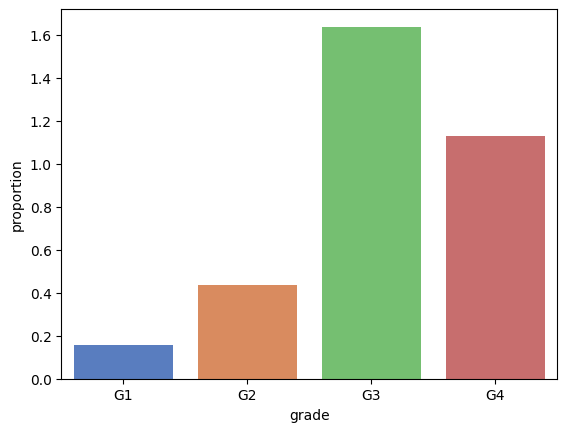

In [14]:
ratios = []
pairs = [
    ('G2', 'G1'),
    ('G3', 'G2'),
    ('G4', 'G3'),
]
for change, reference in pairs:
    print(f'\n{change} vs {reference}')
    cont = pd.DataFrame(columns=[change, reference], index=['YES', 'NO'], data=[[0, 0],[0, 0]])
    cont.loc['YES', reference] = grade_df[reference]['YES']
    cont.loc['YES', change] = grade_df[change]['YES']
    cont.loc['NO', reference] = grade_df[reference]['NO']
    cont.loc['NO', change] = grade_df[change]['NO']
    print(cont)
    print()
    res = odds_ratio(cont)
    ci = res.confidence_interval(confidence_level=0.95)
    print(f'odds ratio: {res.statistic:0.2f}')
    print(f'p-value: [{ci.low:0.2f}, {ci.high:0.2f}]')
    ratios.append((f'{reference}->{change}', res.statistic, ci.low, ci.high))


G2 vs G1
          G2      G1
YES     4568     766
NO   1044401  481143

odds ratio: 2.75
p-value: [2.54, 2.97]

G3 vs G2
         G3       G2
YES   12232     4568
NO   734333  1044401

odds ratio: 3.81
p-value: [3.68, 3.94]

G4 vs G3
         G4      G3
YES    2052   12232
NO   179529  734333

odds ratio: 0.69
p-value: [0.65, 0.72]


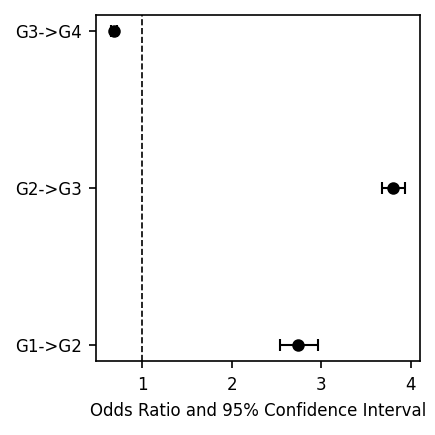

In [15]:

plt.figure(figsize=(3, 3), dpi=150)
yvals = [r[0] for r in ratios]
xvals = [r[1] for r in ratios]
xerrs = [[r[1] - r[2] for r in ratios], [r[3] - r[1] for r in ratios]]
plt.errorbar(y=yvals, x=xvals, xerr=xerrs,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
plt.show()

# OR(common vs uncommon)
# OR(common G1 vs uncommon G1)
# OR(common G2 vs uncommon G2)
# ...


In [16]:
# T-stage
df = deepcopy(master)
df['last_t_stage'] = df['t_stages'].apply(get_last)

# TODO ask Chris about this
temp = df.loc[df['t_stages'] != df['last_t_stage']]
temp[['t_stages', 'last_t_stage']]
# print(f'Total records: {df.shape[0]}')
# print(f'Multiple tumors records: {temp.shape[0]}')
# print(f'Prevalence: {(temp.shape[0]/df.shape[0])*100}')

# TODO ask Chris about this
df[["last_t_stage", "bm_status"]].groupby("last_t_stage").value_counts()

# TODO mapping
# target: {T1, T2, T3, T4}
# - ignore T0
# - ignore Ta, Tis, Tispd etc. 
# - T1a -> T1
df.loc[df['bm_status'] == 'YES'][['last_t_stage']].value_counts(sort=True, ascending=False)

KeyError: 't_stages'

----------

#### Incidence

The proportion of at-risk subjects who develop the outcome of interest.

The number of new cases over a time period divided by the total person-time at risk during that time period.


In [ ]:
# incidence
# total incidence (2010-2020)
# add field for person-time
from copy import deepcopy
df = deepcopy(master[master['timepoint_first'] != master['timepoint_last']])

# subset by 'at risk'
df = df.loc[df['bm_existing'] == 'NO']

# subset by time period
df['tp1'] = df['timepoint_first']
df['tp2'] = df[["timepoint_last", "death_year"]].max(axis=1)
df = df.loc[df['tp2'] < 2021]
df['person_years'] = df['tp2'] - df['tp1']
df[['tp1', 'tp2', 'person_years']]

In [ ]:

def do_mutual_information(df: pd.DataFrame, cat1: str, cat2: str, top: Optional[int]=None, should_print: bool=False) -> None:
    print(f'{cat1} vs {cat2} ---\n')
    temp = df[[cat1, cat2]]
    temp = temp.dropna()
    # temp = temp.reset_index(drop=True)
    if top is not None:
        temp = temp.head(top)
    print(f'Using {temp.shape[0]} records.')
    if should_print:
        print(temp.head(10))
        print()
    # c_matrix = confusion_matrix(temp, cat2, cat1)
    # print(c_matrix)
    # print()

    # mi1 = mutual_info_score(labels_pred=temp[cat1], labels_true=temp[cat2])
    # mi2 = mutual_info_score(labels_true=None, labels_pred=None, contingency=c_matrix)
    mi3 = normalized_mutual_info_score(labels_pred=temp[cat1], labels_true=temp[cat2])
    
    # print(f'Mutual information Arrays: {mi1:0.3f}')
    # print(f'Mutual information Confusion: {mi2:0.3f}')
    print(f'Mutual information Normalized: {mi3:0.3f}\n\n')
    
    # plt.figure(figsize=(5, 5), dpi=100)
    # prev_df = pd.DataFrame(columns=c_matrix.columns, index=c_matrix.index)
    # for field in c_matrix.columns:
    #     c_matrix[field] = (c_matrix[field] / c_matrix[field].sum())
    # print(c_matrix)
    # c_matrix = c_matrix.sort_index(ascending=False)
    # sns.barplot(c_matrix.T['YES'])
    